# <span style="color:black; font-weight:bold;">VisiumHD Human tonsils Sample Integration Tutorial</span>
+ <span style="color:black; font-weight:bold;">Creator</span>: Bingjie Dai (17516970902@163.com)
+ <span style="color:black; font-weight:bold;">Date of Creation</span>: 10.12.2025
+ <span style="color:black; font-weight:bold;">Date of Last Modification</span>: 10.12.2025
+ <span style="color:black; font-weight:bold;">Download</span>: VisiumHD Human tonsils Sample Integration data used in the tutorial are available at [FreshFrozenVisiumHDP1.h5ad](https://drive.google.com/open?id=16Hh1T34Cisj41x3QtRphtKG2dtsZ_CC-&usp=drive_fs) and [FFIFVisiumHDP2.h5ad](https://drive.google.com/open?id=11z920Equ8WV4dpPbNeVDCdvNoazT-Gbr&usp=drive_fs)
In this tutorial we apply SpaLP to 2 Sample Integration (FreshFrozenVisiumHDP1/FFIFVisiumHDP2) of the Human tonsils dataset from [10x Genomics](https://www.10xgenomics.com/datasets)

<span style="color:black; font-weight:bold;">The dataset have:</span>   
+ <span style="color:black; font-weight:bold;">FreshFrozen Visium HD P1</span>: 553,820 cells and 18,085 genes   
+ <span style="color:black; font-weight:bold;">FFIF Visium HD P2</span>: 679,294 cells and 18,085 genes    
+ <span style="color:black; font-weight:bold;">After integration Total</span>: 1,216,483 cells and 1168 genes

In [1]:
from SpaLP.utils import prepare_inputs, set_seed,create_new_color_dict,Graph
from SpaLP.RandLA import SpatialAutoencoder
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
set_seed(7)

## <span style="color:black; font-weight:bold;">Loading VisiumHD Human tonsils Sample Integration data</span>
The VisiumHD Human tonsils Sample Integration data contains 2 spatial slices, 553,820 cells and 679,294 cells.

In [4]:
adata1=sc.read_h5ad('/home/dbj/SpaLP/Tutorial data/FreshFrozenVisiumHDP1.h5ad')
adata1.var_names_make_unique()
adata1.obs['batch']='P1'
adata2=sc.read_h5ad('/home/dbj/SpaLP/Tutorial data/FFIFVisiumHDP2.h5ad')
adata2.var_names_make_unique()
adata2.obs['batch']='P2'
adata1,adata2

(AnnData object with n_obs × n_vars = 553820 × 18085
     obs: 'in_tissue', 'array_row', 'array_col', 'batch'
     var: 'gene_ids', 'feature_types', 'genome'
     uns: 'spatial'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 679294 × 18085
     obs: 'in_tissue', 'array_row', 'array_col', 'batch'
     var: 'gene_ids', 'feature_types', 'genome'
     uns: 'spatial'
     obsm: 'spatial')

## <span style="color:black; font-weight:bold;">Data preprocessing</span>
We use [scanpy](https://scanpy.readthedocs.io/en/stable/installation.html) package to select top2000 HVGs in each  sample  
We preprocess each sample separately and combine them as standard processed expression matrix.

In [5]:
sc.pp.highly_variable_genes(adata1, n_top_genes=2000, flavor='seurat_v3')
adata1 = adata1[:,adata1.var.highly_variable]
sc.pp.highly_variable_genes(adata2, n_top_genes=2000, flavor='seurat_v3')
adata2 = adata2[:,adata2.var.highly_variable]
adata_batch_list = [adata1,adata2]
adata = ad.concat(adata_batch_list, join="inner")

In [6]:
adata

AnnData object with n_obs × n_vars = 1233114 × 1168
    obs: 'in_tissue', 'array_row', 'array_col', 'batch'
    obsm: 'spatial'

In [7]:
adatas = []
for batch in adata.obs['batch'].unique():
    a = adata[adata.obs['batch'] == batch].copy()
    sc.pp.normalize_total(a,inplace=True)
    sc.pp.log1p(a)
    sc.pp.scale(a)
    sc.pp.filter_cells(a,min_genes=1)
    adatas.append(a)

adata = ad.concat(adatas, join="inner")
adata.obsm['feat']=adata.X

In [8]:
adata

AnnData object with n_obs × n_vars = 1216483 × 1168
    obs: 'in_tissue', 'array_row', 'array_col', 'batch', 'n_genes'
    obsm: 'spatial', 'feat'

## <span style="color:black; font-weight:bold;">Compute Spatial Neighbor Graph and build the neighbor index matrix</span>
We compute the spatial Graph using 4 neighbors in Visium HD human tonsils Sample Integration data. k=4  
We will compute a separate spatial neighbor index matrix for each sample and combine them as disconnected components. 

In [9]:
graphs = []
for batch in adata.obs['batch'].unique():
    a = adata[adata.obs['batch'] == batch].copy()
    graph = prepare_inputs(a, k=4, device=device)
    graphs.append(graph)

In [10]:
all_features = torch.cat([g.features for g in graphs], dim=0)
all_neighbor_idx = []
offset = 0
for g in graphs:
    all_neighbor_idx.append(g.neighbor_idx + offset)
    offset += g.features.shape[0]
all_neighbor_idx = torch.cat(all_neighbor_idx, dim=0)
graph = Graph(all_features, all_neighbor_idx)

## <span style="color:black; font-weight:bold;">Define Parameters</span>
The hidden layer dimension is 32, the Adam optimizer is used to optimize the model, the learning rate lr is 0.001, and the model is trained for 200 epochs.

In [11]:
in_channels = graph.features.shape[1]
model = SpatialAutoencoder(in_channels, out_channels=32).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
set_seed(7)
epochs = 200
pbar = tqdm(range(epochs), desc="Training",ncols=200)
for epoch in pbar:
    start_time = time.time()
    model.train()
    optimizer.zero_grad()
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    loss = criterion(reconstructed, graph.features)
    loss.backward()
    optimizer.step()
    elapsed = time.time() - start_time
    pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

Training: 100%|█████████████████████████| 200/200 [00:44<00:00,  4.46it/s, Epoch=199, Loss=0.9726]


## <span style="color:black; font-weight:bold;">Generate cell embedding and reconstructed gene expression</span>
Cell embedding was saved in adata.obsm[<span style="color:red;">'SpaLP'</span>]. Reconstructed gene expression is constructed as adata2

In [13]:
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

### Cell embedding

In [14]:
adata.obsm['SpaLP']=embedding

### Reconstructed gene expression

In [15]:
adata2=sc.AnnData(reconstructed)
adata2.obs=adata.obs
adata2.var=adata.var
adata2.uns=adata.uns
adata2.obsm=adata.obsm

## <span style="color:black; font-weight:bold;">Identify Niches and Visualization of Multi-slice Integration embedding Using UMAP</span>
We compute Leiden clustering based on the SpaLP embeddings to identify spatial niches.

In [16]:
sc.pp.neighbors(adata, use_rep='SpaLP')
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution=0.2,key_added='SpaLP')

### <span style="color:black; font-weight:bold;">Multi-slice Integration embedding</span>

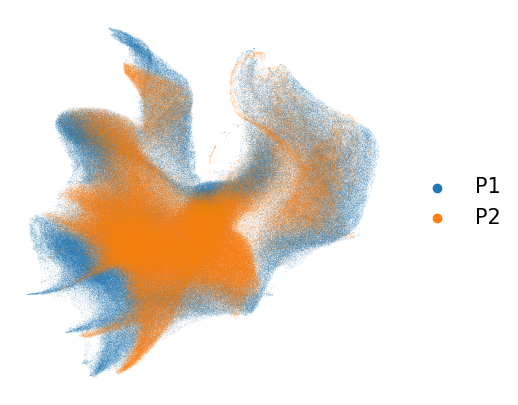

In [23]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['font.size'] = 15
sc.pl.umap(adata=adata,color='batch',title='',size=0.2,colorbar_loc=None,frameon=False)

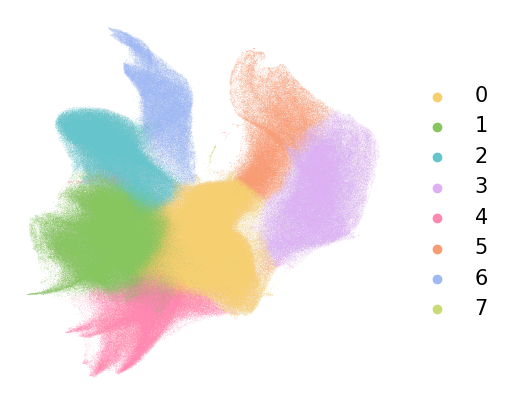

In [22]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['font.size'] = 15
latent_cluster_colors = create_new_color_dict(adata=adata,cat_key='SpaLP')
sc.pl.umap(adata=adata,color='SpaLP',title='',size=0.3,colorbar_loc=None,frameon=False,palette=latent_cluster_colors)

## <span style="color:black; font-weight:bold;">Multi-slice Niche identified by SpaLP</span>

In [26]:
adata.obsm['spatial'][:, 1] = -adata.obsm['spatial'][:, 1]

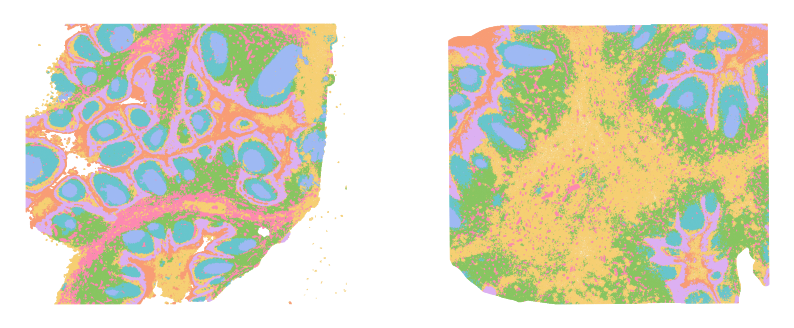

In [27]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 15
latent_cluster_colors = create_new_color_dict(adata=adata,cat_key='SpaLP')
samples = adata.obs['batch'].unique().tolist()
fig, axs = plt.subplots(1, len(samples), figsize=(5 * len(samples), 4))
if len(samples) == 1:
    axs = [axs]
for idx, sample in enumerate(samples):
    sc.pl.embedding(adata=adata[adata.obs['batch'] == sample],basis='spatial',color=['SpaLP'],legend_loc=None,frameon=False,title='',palette=latent_cluster_colors,ax=axs[idx],show=False,size=1)

## <span style="color:black; font-weight:bold;">Original gene expression spatial map</span>

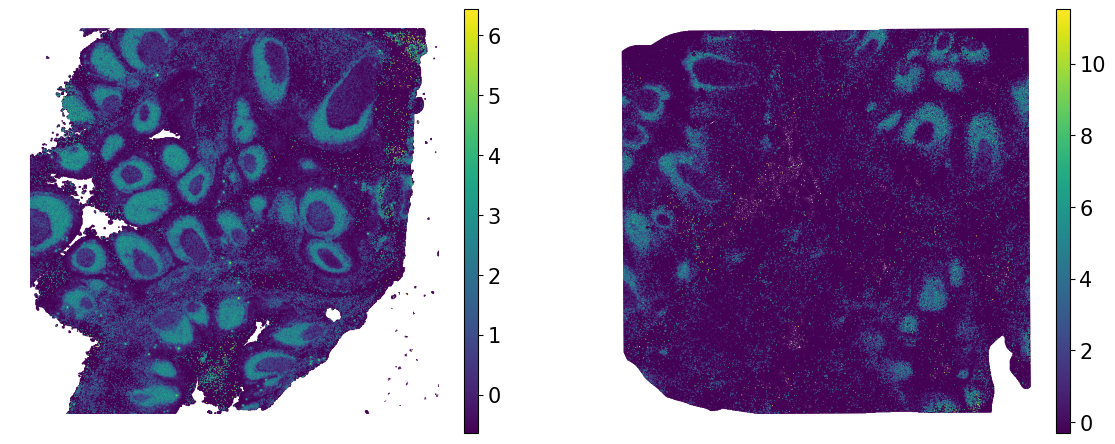

In [40]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 15
latent_cluster_colors = create_new_color_dict(adata=adata,cat_key='SpaLP')
samples = adata.obs['batch'].unique().tolist()
fig, axs = plt.subplots(1, len(samples), figsize=(7 * len(samples), 5.5))
if len(samples) == 1:
    axs = [axs]
for idx, sample in enumerate(samples):
    sc.pl.embedding(adata=adata[adata.obs['batch'] == sample],basis='spatial',color=['IGHD'],legend_loc=None,frameon=False,title='',palette=latent_cluster_colors,ax=axs[idx],show=False,size=2)

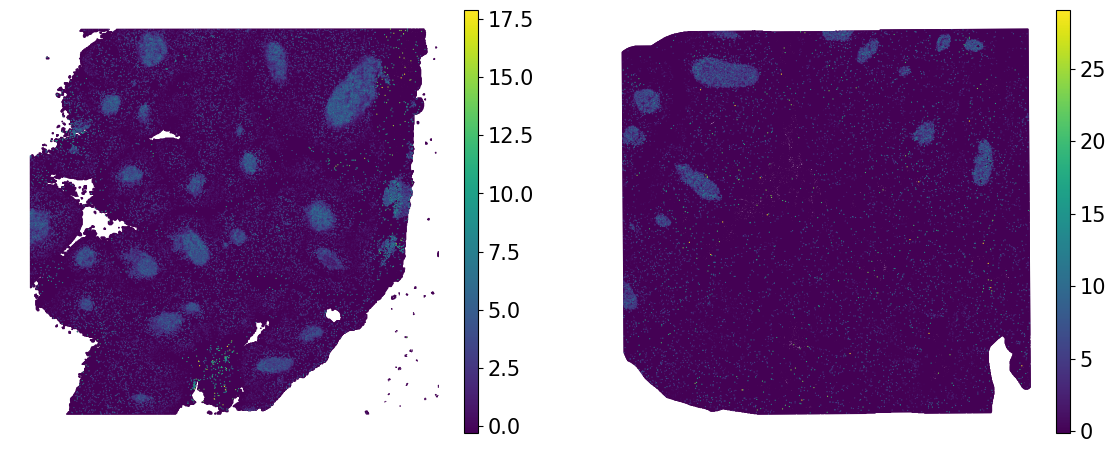

In [38]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 15
latent_cluster_colors = create_new_color_dict(adata=adata,cat_key='SpaLP')
samples = adata.obs['batch'].unique().tolist()
fig, axs = plt.subplots(1, len(samples), figsize=(7 * len(samples), 5.5))
if len(samples) == 1:
    axs = [axs]
for idx, sample in enumerate(samples):
    sc.pl.embedding(adata=adata[adata.obs['batch'] == sample],basis='spatial',color=['MEF2B'],legend_loc=None,frameon=False,title='',palette=latent_cluster_colors,ax=axs[idx],show=False,size=3)

## <span style="color:black; font-weight:bold;">Reconstructed gene expression spatial map</span>

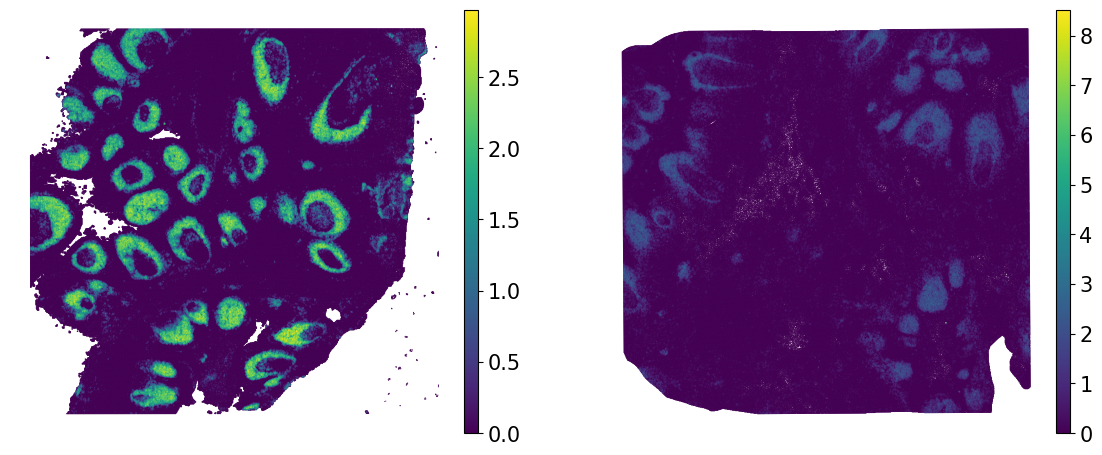

In [36]:
adata2.obsm['spatial'][:, 1] = -adata2.obsm['spatial'][:, 1]
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 15
latent_cluster_colors = create_new_color_dict(adata=adata,cat_key='SpaLP')
samples = adata.obs['batch'].unique().tolist()
fig, axs = plt.subplots(1, len(samples), figsize=(7 * len(samples), 5.5))
if len(samples) == 1:
    axs = [axs]
for idx, sample in enumerate(samples):
    sc.pl.embedding(adata=adata2[adata2.obs['batch'] == sample],basis='spatial',color=['IGHD'],legend_loc=None,frameon=False,title='',palette=latent_cluster_colors,ax=axs[idx],show=False,size=2)

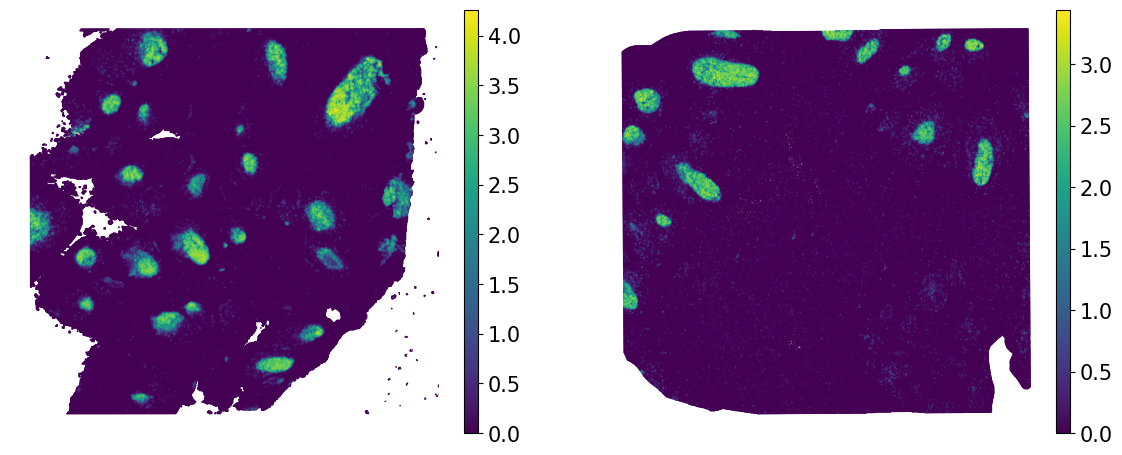

In [37]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 15
latent_cluster_colors = create_new_color_dict(adata=adata,cat_key='SpaLP')
samples = adata.obs['batch'].unique().tolist()
fig, axs = plt.subplots(1, len(samples), figsize=(7 * len(samples), 5.5))
if len(samples) == 1:
    axs = [axs]
for idx, sample in enumerate(samples):
    sc.pl.embedding(adata=adata2[adata2.obs['batch'] == sample],basis='spatial',color=['MEF2B'],legend_loc=None,frameon=False,title='',palette=latent_cluster_colors,ax=axs[idx],show=False,size=3)